In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using Theano backend.


In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [5]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [6]:
df = pd.read_csv('./data/train.tsv', sep='\t', header=0)

In [7]:
# reading data
# df = pd.read_excel('dataset.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Sentiment'])))

('Shape of dataset ', (156060, 4))
Index([u'PhraseId', u'SentenceId', u'Phrase', u'Sentiment'], dtype='object')
('No. of unique classes', 5)


In [8]:
macronum=sorted(set(df['Sentiment']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['Sentiment']=df['Sentiment'].apply(fun)

In [10]:
texts = []
labels = []


for idx in range(df.Phrase.shape[0]):
#     print(df.Phrase[idx])
    text = df.Phrase[idx]
    texts.append(clean_str(text))

for idx in df['Sentiment']:
    labels.append(idx)

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

('Number of Unique Tokens', 15276)


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

('Shape of Data Tensor:', (156060, 100))
('Shape of Label Tensor:', (156060, 5))


In [14]:
embeddings_index = {}
GLOVE_LOC = '../glove.6B/glove.6B.100d.txt'
f = open(GLOVE_LOC)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [15]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(32, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(32, 5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(5)(l_cov2)
# l_cov3 = Conv1D(32, 5, activation='relu')(l_pool2)
# l_pool3 = MaxPooling1D(5)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool1)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1527700   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 96, 32)            16032     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 19, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                19488     
_________________________________________________________________
dense_9 (Dense)              (None, 

In [26]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=5, batch_size=512,callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 612s 5ms/step - loss: 1.0122 - acc: 0.5995 - val_loss: 0.9891 - val_acc: 0.6047

Epoch 00001: val_acc improved from -inf to 0.60467, saving model to model_cnn.hdf5
Epoch 2/5
124848/124848 [==============================] - 616s 5ms/step - loss: 0.9436 - acc: 0.6239 - val_loss: 0.9581 - val_acc: 0.6174

Epoch 00002: val_acc improved from 0.60467 to 0.61736, saving model to model_cnn.hdf5
Epoch 3/5
124848/124848 [==============================] - 621s 5ms/step - loss: 0.9016 - acc: 0.6417 - val_loss: 0.9387 - val_acc: 0.6258

Epoch 00003: val_acc improved from 0.61736 to 0.62585, saving model to model_cnn.hdf5
Epoch 4/5
124848/124848 [==============================] - 602s 5ms/step - loss: 0.8696 - acc: 0.6561 - val_loss: 0.9268 - val_acc: 0.6320

Epoch 00004: val_acc improved from 0.62585 to 0.63200, saving model to model_cnn.hdf5
Epoch 5/5
124848/124848 [=======================

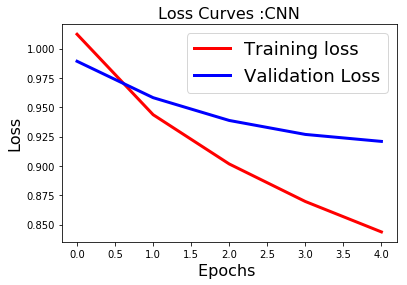

In [27]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

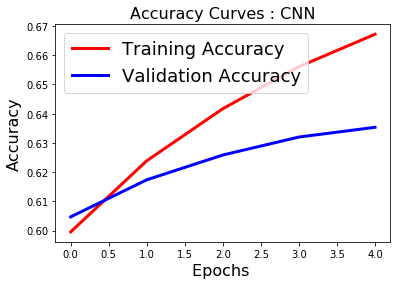

In [28]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [29]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [30]:
from PIL import Image
display(Image.open('cnn_model.png'))

IOError: [Errno 2] No such file or directory: 'cnn_model.png'